## R script for OMOP GIS use cases

### Setup

In [97]:
library(DBI)

# make db connection
# for format of database file see db/env/db_conf.txt
db <- read.delim( '../../db/env/local.txt', header=TRUE, sep=' ' )
con <- dbConnect(RPostgres::Postgres(),
                 dbname = toString(db$database[1]),
                 host = toString(db$host[1]),
                 port = 5432,
                 user = toString(db$user),
                 password = toString(db$pass))

# check the connection
dbListTables(con)

[1] "geography_columns"               "geometry_columns"               
 [3] "spatial_ref_sys"                 "raster_columns"                 
 [5] "raster_overviews"                "attr_dindex"                    
 [7] "attr_florida_acs"                "care_site"                      
 [9] "geo_florida_tri_2018"            "condition_occurrence"           
[11] "data_source"                     "locations"                      
[13] "visit_occurrence"                "persons"                        
[15] "utm_grid"                        "geo_miamidade_census_tract_2018"
[17] "measurement"                     "geo_us_counties"                
[19] "attr_epa_aqi_2019"               "geo_index"                      
[21] "attr_florida_tri_2018"           "location_history"               
[23] "site_history"                    "sites"                          
[25] "acs_income_bmi"                  "dindex_bmi"                     
[27] "attr_index"                      "md_hexbins_1km"

### Examples

### 1 - get all patients within a particular census tract
UTM 17N - EPSG 32617 (meters)

In [ ]:
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT PS.*,L.geom_local FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 CT ON ST_Within(L.geom_local, CT.geom_local)
          WHERE CT.source_id_value = '12086009100'
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

### 2 - get all patients within a census tract with annual income below $15,000

**Use Case:** Patients with demographic criteria X that live within area Y, for duration Z  
**Example:** Patients who are over 100 years old that live within the TMC hospital service area for over 5 years  
**Functionality Requirements:** 3a, 3b, 4b  

**note:** this does not have the 'duration' component 

UTM 17N - EPSG 32617 (meters)

In [ ]:
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT PS.*,L.geom_local from persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN locations L on L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 CT ON ST_Within(L.geom_local, CT.geom_local)
          JOIN attr_florida_acs ATT ON ATT.geo_record_id = CT.geo_record_id
          WHERE ATT.value_as_number < 15000
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

### 3 - get all patients within 1km of a carcinogen emitter (TRI data)

**Use Case:** Patients who live within distance X of non-clinical feature Y  
**Example:** Patients who live within 5 miles of a paper mill  
**Functionality Requirements:** 3a, 4a, 6a/6b, 3e 


UTM 17N - EPSG 32617 (meters) - ohdsi schema

In [ ]:
sql <- "WITH buffers AS (
            SELECT HP.name, ST_Buffer(HP.geom_local,1000) AS geom_local FROM attr_florida_tri_2018 HA
            JOIN geo_florida_tri_2018 HP ON HA.geo_record_id = HP.geo_record_id
            WHERE (HA.qualifier_concept_id = 1 or HA.qualifier_concept_id = 3)
        ) 
        SELECT PS.*,L.geom_local FROM persons PS 
        JOIN location_history LH ON PS.person_id = LH.entity_id 
        JOIN locations L ON L.location_id = LH.location_id 
        JOIN buffers ON ST_Within(L.geom_local, buffers.geom_local)"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

No WITH, but very slow (never completed on local machine)

In [ ]:
sql <- "SELECT row_number() over () AS _uid_,* FROM (
            SELECT PS.*,L.geom_local FROM persons PS 
            JOIN location_history LH ON PS.person_id = LH.entity_id 
            JOIN locations L ON L.location_id = LH.location_id 
            JOIN geo_florida_tri_2018 HP ON ST_Within(L.geom_local, ST_Buffer(HP.geom_local,1000))
            JOIN attr_florida_tri_2018 HA ON HP.geo_record_id = HA.geo_record_id
            WHERE HA.qualifier_concept_id = 1 or HA.qualifier_concept_id = 3
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

### 4 - get all patients within census block that contains a carcinogen emitter (TRI data)

**Use Case:** Patients who live in an area that contains a non-clinical feature Y	
**Example:** Paper mill in same census tract as residence	
**Functionality Requirements:** 3a, 4a, 4b

UTM 17N - EPSG 32617 (meters)

In [ ]:
sql <- "SELECT row_number() OVER () AS _uid_,* FROM (
          WITH CG AS (
            SELECT HZP.name, HZP.geom_local FROM attr_florida_tri_2018 ATT
            INNER JOIN geo_florida_tri_2018 HZP ON ATT.geo_record_id = HZP.geo_record_id
            WHERE ATT.qualifier_concept_id = 1 or ATT.qualifier_concept_id = 3
          ), 
          CT AS (
            SELECT DD.source_id_value, DD.geom_local FROM geo_miamidade_census_tract_2018 DD
            JOIN CG ON ST_Contains(DD.geom_local,CG.geom_local)
          ) 
          SELECT PS.*,L.geom_local FROM persons PS 
          INNER JOIN location_history LH ON PS.person_id = LH.entity_id 
          INNER JOIN locations L ON L.location_id = LH.location_id 
          JOIN CT ON ST_Within(L.geom_local, CT.geom_local) 
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

### 5 - get all patients within 1km of network care sites

**Use Case:** Given a list of care sites, patients who lived within Y miles on date range Z  	
**Example:** For a list of in-network care sites, which patients live within 10 miles  
**Functionality Requirements:** 3a, 3b, 4a, 6b

UTM 17N - EPSG 32617 (meters)

In [ ]:
sql <- "SELECT row_number() OVER () AS _uid_,* FROM (
          WITH CB AS (
            SELECT CS.care_site_name, ST_Buffer(CSL.geom_local,1000) AS geom_local FROM care_site CS
            INNER JOIN site_history SH ON SH.entity_id = CS.care_site_id
            INNER JOIN sites CSL ON SH.site_id = CSL.site_id
            WHERE CS.place_of_service_concept_id = 0
          ) 
          SELECT PS.*,L.geom_local FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN CB ON ST_Within(L.geom_local, CB.geom_local)
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

### 6 - get all patients who are more than 5 kilometers from a care site

**Use Case:** Patients who traveled over Y miles for primary care visit  	
**Example:** Patients who must travel greater than 50 miles to PCP
**Functionality Requirements:** 3a, 3b, 6a

UTM 17N - EPSG 32617 (meters)

In [ ]:
sql <- "SELECT row_number() OVER () AS _uid_,* FROM (
          WITH CB AS (
            SELECT CS.care_site_name, ST_Buffer(CSL.geom_local,5000) AS geom_local FROM care_site CS
            INNER JOIN site_history SH ON SH.entity_id = CS.care_site_id
            INNER JOIN sites CSL ON SH.site_id = CSL.site_id
            WHERE CS.place_of_service_concept_id = 0
          ) 
          SELECT persons.*,L.geom_local FROM persons 
          INNER JOIN location_history LH ON person_id = LH.entity_id 
          INNER JOIN locations L ON L.location_id = LH.location_id
          WHERE person_id NOT IN (
            SELECT PS.person_id FROM persons PS
            INNER JOIN location_history LH ON PS.person_id = LH.entity_id 
            INNER JOIN locations L ON L.location_id = LH.location_id 
            JOIN CB ON ST_Within(L.geom_local, CB.geom_local)
          )
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

## 7 - get avg BMI from patient measures and avg attr from ACS

get centroids for bivariate mapping?

In [ ]:
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT 
            AVG(MS.value_as_number) as avg_bmi,
            ATT.value_as_number as avg_income,
            DD.name,
            DD.geom_local
          FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN measurement MS ON PS.person_id = MS.person_id
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 DD ON ST_Within(L.geom_local, DD.geom_local)
          JOIN attr_florida_acs ATT ON ATT.geo_record_id = DD.geo_record_id
          GROUP BY DD.name, ATT.value_as_number, DD.geom_local
        ) _subq1"
res <- dbSendQuery(con,sql)
dbFetch(res)
dbClearResult(res)

## libraries for leaflet visualization

In [98]:
library(leaflet)
library(sf)
library(rgdal)
library(geojsonio)
library(ggplot2)

## Quick leaflet visualization of point data

In [99]:
# persons in census tract 12086009100
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT PS.*,L.geom_WGS84 FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 CT ON ST_Within(L.geom_local, CT.geom_local)
          WHERE CT.source_id_value = '12086009100'
          LIMIT 100
        ) _subq1"
pftrs <- st_read(con,query=sql)

In [100]:
# just the census tracts as polygons
sql <- "SELECT source_id_value,geom_wgs84 from geo_miamidade_census_tract_2018"
ctpolftrs <- st_read(con,query=sql)

In [101]:
# plot(pftrs$geom_wgs84)

In [102]:
m <- leaflet(data=pftrs$geom_wgs84) %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addMarkers() %>% # Add default markers from data
  addPolygons(data=ctpolftrs,
              fillColor = "#e41a1c", 
              fillOpacity = 0.0, 
              stroke = "#690E0E",
              weight = 0.7,
              label = ~source_id_value,
              labelOptions = labelOptions(style = list("font-weight" = "normal", padding = "3px 8px"), textsize = "13px", direction = "auto"),
              group = "census_tracts",
              highlight = highlightOptions(color = "black", weight = 4, bringToFront = TRUE))

In [103]:
m

HTML widgets cannot be represented in plain text (need html)

## quick leaflet visualization of bivariate polygon data

In [104]:
# census tract centroids with avg BMI (UHealth) and avg income (ACS)
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT 
            AVG(MS.value_as_number) as avg_bmi,
            ATT.value_as_number as avg_income,
            DD.source_id_value,
            ST_Centroid(DD.geom_wgs84)
          FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN measurement MS ON PS.person_id = MS.person_id
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 DD ON ST_Within(L.geom_local, DD.geom_local)
          JOIN attr_florida_acs ATT ON ATT.geo_record_id = DD.geo_record_id
          GROUP BY DD.source_id_value, ATT.value_as_number, DD.geom_wgs84
        ) _subq1"
ctftrs <- st_read(con,query=sql)

In [105]:
#bmi_pal <- colorNumeric(palette = "magma",domain = ctftrs$avg_bmi)
#bmi_pal <- colorBin("magma", ctftrs$avg_bmi, 9, pretty = TRUE)
bmi_pal <- colorQuantile("magma", ctftrs$avg_bmi, 7)

In [106]:
m <- leaflet(ctftrs) %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addCircles(
    weight = 1,
    radius = ~sqrt(avg_income) * 2,
    fillColor = ~bmi_pal(avg_bmi),
    fillOpacity = 0.8
  ) %>% 
  addPolygons(data=ctpolftrs,
              fillColor = "#e41a1c", 
              fillOpacity = 0.0, 
              stroke = "#690E0E",
              weight = 0.7,
              label = ~source_id_value,
              labelOptions = labelOptions(style = list("font-weight" = "normal", padding = "3px 8px"), textsize = "13px", direction = "auto"),
              group = "census_tracts",
              highlight = highlightOptions(color = "black", weight = 4, bringToFront = TRUE))

In [107]:
m

HTML widgets cannot be represented in plain text (need html)

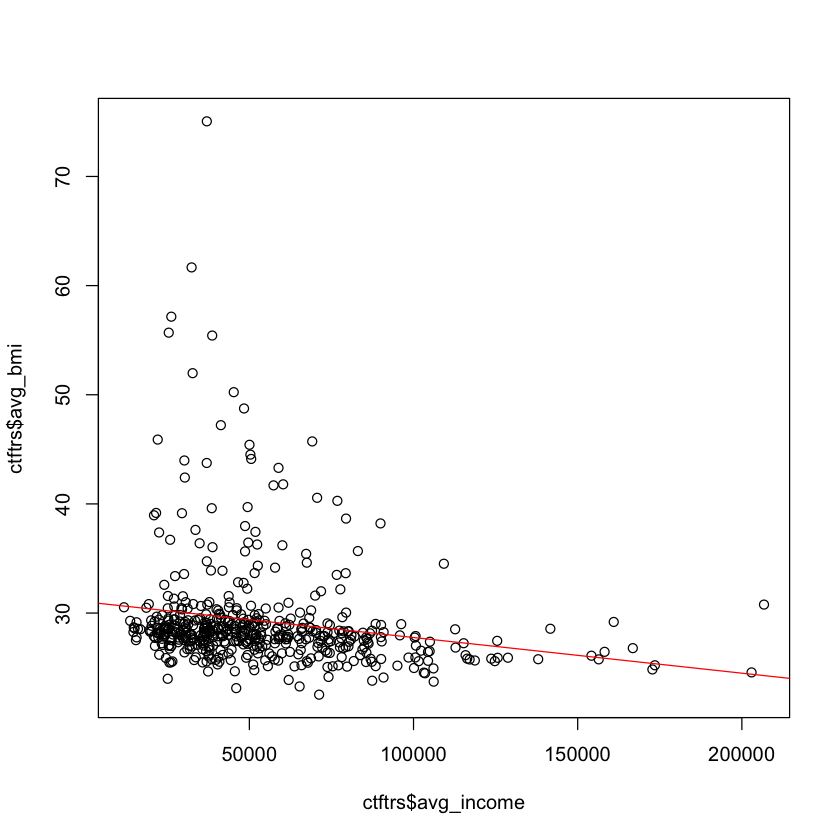

In [12]:
plot(ctftrs$avg_income,ctftrs$avg_bmi)
abline(lm(ctftrs$avg_bmi~ctftrs$avg_income), col="red")

In [13]:
model <- lm(ctftrs$avg_bmi~ctftrs$avg_income)
summary(model)


Call:
lm(formula = ctftrs$avg_bmi ~ ctftrs$avg_income)

Residuals:
   Min     1Q Median     3Q    Max 
-6.404 -2.233 -1.235 -0.015 45.231 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        3.103e+01  4.721e-01  65.731  < 2e-16 ***
ctftrs$avg_income -3.269e-05  7.683e-06  -4.255  2.5e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.067 on 502 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.03481,	Adjusted R-squared:  0.03288 
F-statistic:  18.1 on 1 and 502 DF,  p-value: 2.498e-05


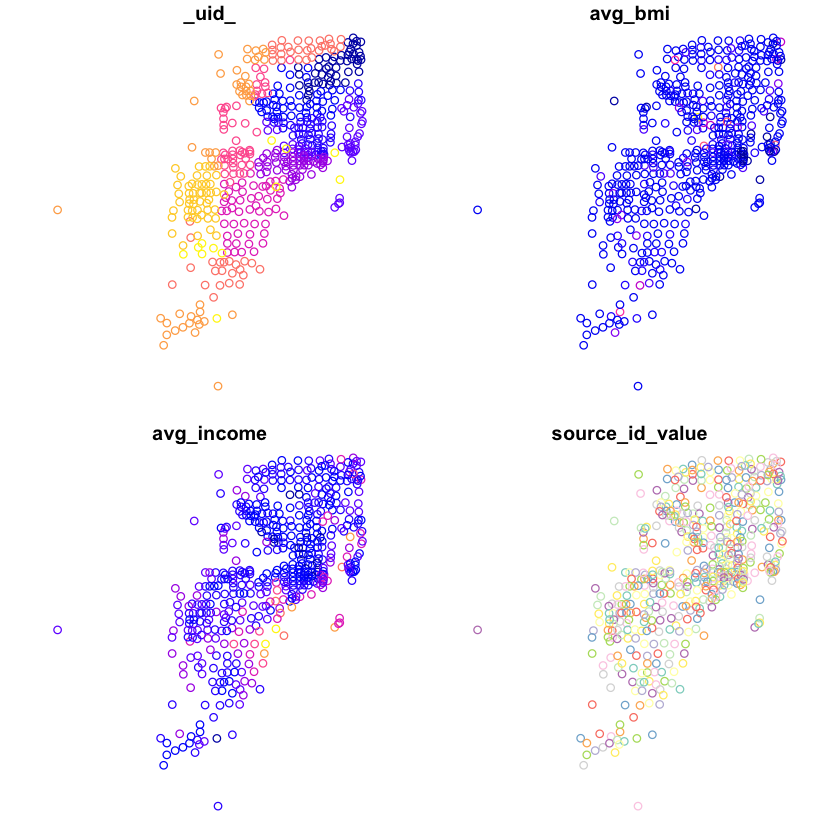

In [14]:
plot(ctftrs)

In [15]:
p <- ggplot() + 
  geom_sf(data=ctpolftrs,
      aes(
          fill = NA,
          stroke = 0.23
      ),
      shape = 2
  ) + 
  scale_fill_manual(values = c('dodgerblue', 'firebrick')) + 
  geom_sf(data=ctftrs,
      aes(
          size = avg_income, 
          colour = avg_bmi,
          stroke = 0.5
      ),
      alpha = 0.7
  ) +
  scale_colour_fermenter(palette = "YlGnBu", direction = -1)

In [16]:
options(repr.p.width=10,repr.p.height=6)

Warning message:
"Removed 8 rows containing missing values (geom_sf)."


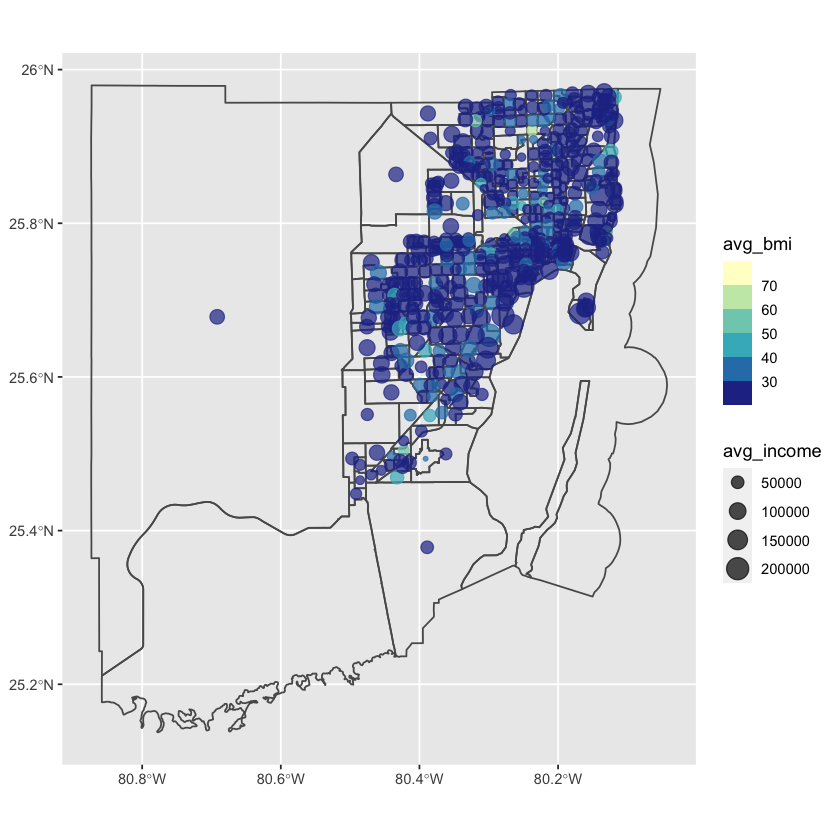

In [17]:
p

## basic vis of BMI and dindex

In [108]:
# census tract centroids with avg BMI (UHealth) and dindex
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT 
            AVG(MS.value_as_number) as avg_bmi,
            ATT.value_as_number as avg_dindex,
            DD.source_id_value,
            ST_Centroid(DD.geom_wgs84)
          FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN measurement MS ON PS.person_id = MS.person_id
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN geo_miamidade_census_tract_2018 DD ON ST_Within(L.geom_local, DD.geom_local)
          JOIN attr_dindex ATT ON ATT.geo_record_id = DD.geo_record_id
          GROUP BY DD.source_id_value, ATT.value_as_number, DD.geom_wgs84
        ) _subq1"
bmi_dindex <- st_read(con,query=sql)

In [109]:
bmi_pal <- colorQuantile("magma", bmi_dindex$avg_bmi, 7)
dindex_pal <- colorQuantile("magma", bmi_dindex$avg_dinex,7)

In [110]:
m <- leaflet(bmi_dindex) %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addCircles(
    weight = 1,
    # dindex is size, BMI is color
    # radius = ~(avg_dindex * 800), 
    # fillColor = ~bmi_pal(avg_bmi),
    # dindex is color, BMI is size
    radius = ~(avg_bmi^1.7), 
    # radius = ~log(avg_bmi) * 80, 
    fillColor = ~dindex_pal(avg_dindex),
    fillOpacity = 0.8
  ) %>% 
  addPolygons(data=ctpolftrs,
              fillColor = "#e41a1c", 
              fillOpacity = 0.0, 
              stroke = "#690E0E",
              weight = 0.7,
              label = ~source_id_value,
              labelOptions = labelOptions(style = list("font-weight" = "normal", padding = "3px 8px"), textsize = "13px", direction = "auto"),
              group = "census_tracts",
              highlight = highlightOptions(color = "black", weight = 4, bringToFront = TRUE))

In [111]:
m

HTML widgets cannot be represented in plain text (need html)

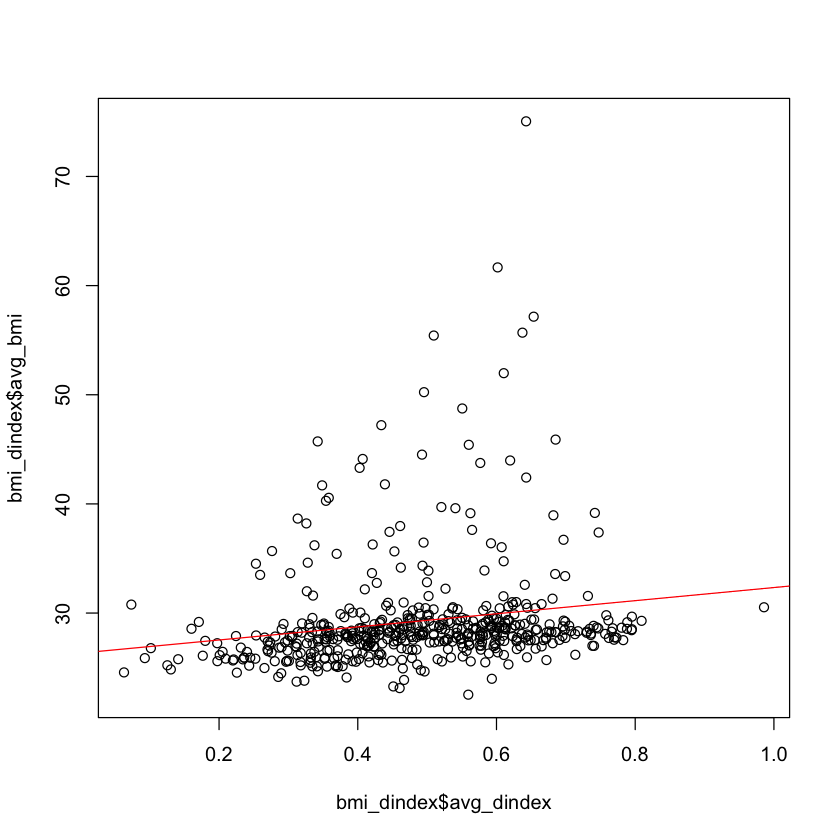

In [60]:
plot(bmi_dindex$avg_dindex,bmi_dindex$avg_bmi)
abline(lm(bmi_dindex$avg_bmi~bmi_dindex$avg_dindex), col="red")

In [61]:
model <- lm(bmi_dindex$avg_bmi~bmi_dindex$avg_dindex)
summary(model)


Call:
lm(formula = bmi_dindex$avg_bmi ~ bmi_dindex$avg_dindex)

Residuals:
   Min     1Q Median     3Q    Max 
-7.174 -2.318 -1.219 -0.073 44.851 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            26.3313     0.7629  34.515  < 2e-16 ***
bmi_dindex$avg_dindex   6.0178     1.4997   4.013 6.91e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.07 on 504 degrees of freedom
Multiple R-squared:  0.03096,	Adjusted R-squared:  0.02904 
F-statistic:  16.1 on 1 and 504 DF,  p-value: 6.915e-05


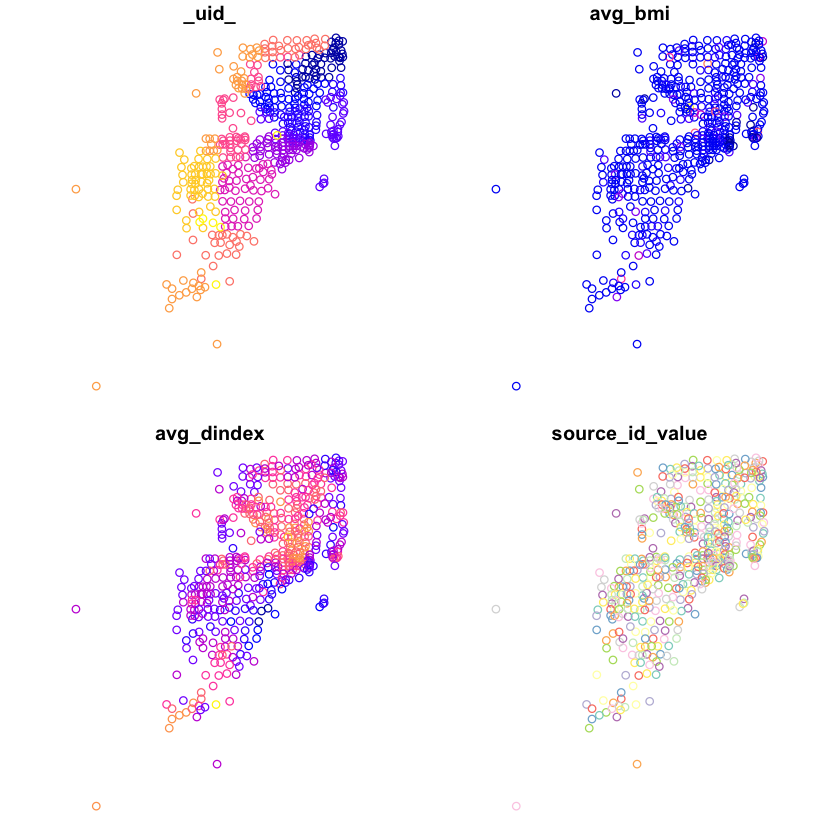

In [62]:
plot(bmi_dindex)

In [73]:
p <- ggplot() + 
  geom_sf(data=ctpolftrs,
      aes(
          fill = NA,
          stroke = 0.23
      ),
      shape = 2
  ) + 
  scale_fill_manual(values = c('dodgerblue', 'firebrick')) + 
  geom_sf(data=bmi_dindex,
      aes(
          size = (avg_bmi^1.6)/5, 
          colour = avg_dindex,
          stroke = 0.5
      ),
      alpha = 0.7
  ) +
  scale_colour_fermenter(palette = "YlGnBu", direction = -1)

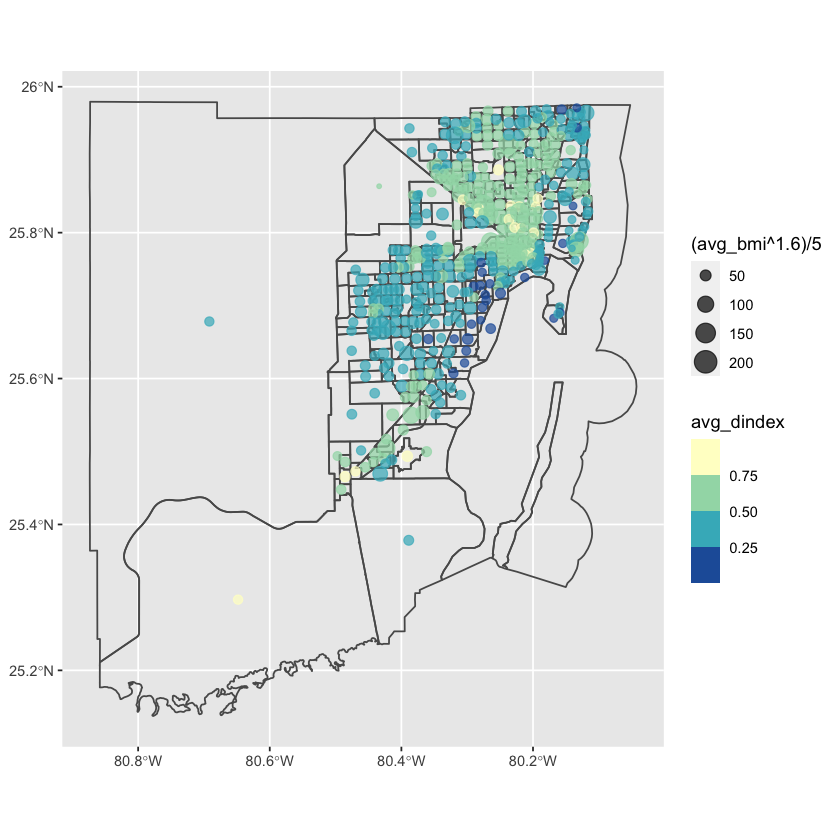

In [74]:
options(repr.p.width=10,repr.p.height=6)
p

## hexbins for measure on persons

In [112]:
# hex bins with avg BMI (UHealth)
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT 
            AVG(MS.value_as_number) as avg_bmi,
            HB.geom_wgs84
          FROM persons PS 
          JOIN location_history LH ON PS.person_id = LH.entity_id 
          JOIN measurement MS ON PS.person_id = MS.person_id
          JOIN locations L ON L.location_id = LH.location_id 
          JOIN md_hexbins_1km HB ON ST_Within(L.geom_local, HB.geom_local)
          GROUP BY HB.geom_wgs84
        ) _subq1"
hbftrs <- st_read(con,query=sql)

In [113]:
# census tract with dindex
sql <- "SELECT row_number() over () AS _uid_,* FROM (
          SELECT 
            ATT.value_as_number as avg_dindex,
            DD.source_id_value,
            DD.geom_wgs84
          FROM geo_miamidade_census_tract_2018 DD
          JOIN attr_dindex ATT ON ATT.geo_record_id = DD.geo_record_id
          GROUP BY DD.source_id_value, ATT.value_as_number, DD.geom_wgs84
        ) _subq1"
dindexftrs <- st_read(con,query=sql)

In [124]:
bmi_pal <- colorQuantile("YlGnBu", hbftrs$avg_bmi, 7)
dindex_pal <- colorQuantile("plasma", dindexftrs$avg_dinex,7)

In [131]:
m <- leaflet(hbftrs) %>%
  # addTiles() %>%  # Add default OpenStreetMap map tiles
  addPolygons(
      fillColor = ~bmi_pal(avg_bmi), 
      fillOpacity = 0.5, 
      stroke = "#690E0E",
      weight = 0.7,
      label = ~avg_bmi,
      labelOptions = labelOptions(style = list("font-weight" = "normal", padding = "3px 8px"), textsize = "13px", direction = "auto"),
      group = "hexbins",
      highlight = highlightOptions(color = "black", weight = 4, bringToFront = TRUE))

In [132]:
m

HTML widgets cannot be represented in plain text (need html)

In [119]:
m <- leaflet(dindexftrs) %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles 
  addPolygons(
      fillColor = ~dindex_pal(avg_dindex), 
      fillOpacity = 0.5, 
      stroke = "#690E0E",
      weight = 0.7,
      label = ~avg_dindex,
      labelOptions = labelOptions(style = list("font-weight" = "normal", padding = "3px 8px"), textsize = "13px", direction = "auto"),
      group = "census_tracts",
      highlight = highlightOptions(color = "black", weight = 4, bringToFront = TRUE))

In [120]:
m

HTML widgets cannot be represented in plain text (need html)